## Imports

In [12]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import sys
import pickle
import wandb

import torch.optim as optim


from utils.miscellaneous import read_config
from utils.miscellaneous import create_folder_structure_MLPvsGNN
from utils.miscellaneous import initalize_random_generators
from utils.wandb_logger import save_response_graphs_in_ML_tracker
from utils.normalization import *
from utils.load import *

from training.train import training
from training.test import testing
from training.models import * 

from utils.visualization import plot_R2, plot_loss
from matplotlib import pyplot as plt

### Parse configuration file + initializations


In [13]:
# read config files
cfg = read_config("config_unrolling.yaml")
# create folder for result
exp_name = cfg['exp_name']
data_folder = cfg['data_folder']
results_folder = create_folder_structure_MLPvsGNN(cfg, parent_folder='./experiments')

all_wdn_names = cfg['network']
initalize_random_generators(cfg, count=0)

# initialize pytorch device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
#torch.set_num_threads(12)

Creating folder: ./experiments/unrolling_WDN0364
cpu


In [14]:
# TO DO: at the moment I am not using the parsed values for batch size and num_epochs ;
# I am not using alpha as well because the loss has no "smoothness" penalty (yet)
batch_size = cfg['trainParams']['batch_size']
num_epochs = cfg['trainParams']['num_epochs']
res_columns = ['train_loss', 'valid_loss', 'test_loss', 'max_train_loss', 'max_valid_loss', 'max_test_loss',
               'min_train_loss', 'min_valid_loss', 'min_test_loss', 'r2_train', 'r2_valid',
               'r2_test', 'total_params', 'total_time', 'test_time']

# Functions

## Models
I will be Creating different models as follows:

* A simple LSTM
* An unrolled version of Heads and Flows, without static variables
* An unrolled version with Heads, Flows and static variables


## Running experiments

In [15]:
for ix_wdn, wdn in enumerate(all_wdn_names):
    print(f'\nWorking with {wdn}, network {ix_wdn + 1} of {len(all_wdn_names)}')

    # retrieve wntr data
    tra_database, val_database, tst_database = load_raw_dataset(wdn, data_folder)
    # reduce training data
    # tra_database = tra_database[:int(len(tra_database)*cfg['tra_prc'])]
    if cfg['tra_num'] < len(tra_database):
        tra_database = tra_database[:cfg['tra_num']]


    # get GRAPH datasets     
    # later on we should change this and use normal scalers from scikit (something is off here)
    tra_dataset, A12_bar = create_dataset(tra_database)
    # number of nodes
    junctions = (tra_database[0].node_type == JUNCTION_TYPE).numpy().sum()
    tanks = (tra_database[0].node_type == TANK_TYPE).numpy().sum()
    output_nodes = len(tra_dataset[0].y[0]) # remove reservoirs
    gn = GraphNormalizer(junctions + tanks, output=['pressure', 'pump_flow'])
    gn = gn.fit(tra_dataset)
    # The normalization messed with the 1H_type since we want unique IDs
    tra_dataset, _ = create_dataset(tra_database, normalizer=gn)
    val_dataset, _ = create_dataset(val_database, normalizer=gn)
    tst_dataset, _ = create_dataset(tst_database, normalizer=gn)
    node_size, edge_size = tra_dataset[0].x.size(-1), tra_dataset[0].edge_attr.size(-1)
    
    # dataloader
    # transform dataset for MLP
    # We begin with the MLP versions, when I want to add GNNs, check Riccardo's code
    A10, A12 = create_incidence_matrices(tra_dataset, A12_bar)
    tra_dataset_MLP, num_inputs, indices = create_dataset_MLP_from_graphs(tra_dataset)
    val_dataset_MLP = create_dataset_MLP_from_graphs(val_dataset)[0]
    tst_dataset_MLP = create_dataset_MLP_from_graphs(tst_dataset)[0]
    tra_loader = torch.utils.data.DataLoader(tra_dataset_MLP,
                                             batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_MLP,
                                             batch_size=batch_size, shuffle=False, pin_memory=True)
    tst_loader = torch.utils.data.DataLoader(tst_dataset_MLP,
                                             batch_size=batch_size, shuffle=False, pin_memory=True)
    # loop through different algorithms
    for algorithm in cfg['algorithms']:
        # Importing of configuration parameters
        hyperParams = cfg['hyperParams'][algorithm]
        all_combinations = ParameterGrid(hyperParams)

        # create results dataframe
        results_df = pd.DataFrame(list(all_combinations))
        results_df = pd.concat([results_df,
                                pd.DataFrame(index=np.arange(len(all_combinations)),
                                             columns=list(res_columns))], axis=1)

        for i, combination in enumerate(all_combinations):
            # wandb.init(project="unrolling-epanet", entity="mertz")
            print(f'{algorithm}: training combination {i + 1} of {len(all_combinations)}\n')
            
            combination['indices'] = indices
            combination['junctions'] = junctions
            combination['num_outputs'] = output_nodes

            # model creation
            model = getattr(sys.modules[__name__], algorithm)(**combination).float().to(device)

            # get combination dictionary to determine how are indices made
            total_parameters = sum(p.numel() for p in model.parameters())
            print("Total number of parameters is", total_parameters)

            # model optimizer
            optimizer = optim.Adam(params=model.parameters(), betas=(0.9, 0.999), **cfg['adamParams'])

            # training
            patience = cfg['earlyStopping']['patience']
            lr_rate = cfg['earlyStopping']['divisor']
            lr_epoch = cfg['earlyStopping']['epoch_frequency']
            alpha = cfg['lossParams']['alpha']
            train_config = {"Patience": patience, "Learning Rate Divisor": lr_rate, "LR Epoch Division": lr_epoch}
            model, tra_losses, val_losses, elapsed_time = training(model, optimizer, tra_loader, val_loader,
                                                                   patience=patience, report_freq=0,
                                                                   n_epochs=num_epochs,
                                                                   alpha=alpha, lr_rate=lr_rate, lr_epoch=lr_epoch,
                                                                   normalization=None, path="experiments", nodes_idx=junctions+tanks)
            
            loss_plot = plot_loss(tra_losses, val_losses, f'{results_folder}/{wdn}/{algorithm}/loss/{i}')
            R2_plot = plot_R2(model, val_loader, f'{results_folder}/{wdn}/{algorithm}/R2/{i}', normalization=gn)[1]
            # store training history and model
            pd.DataFrame(data=np.array([tra_losses, val_losses]).T).to_csv(
                f'{results_folder}/{wdn}/{algorithm}/hist/{i}.csv')
            torch.save(model, f'{results_folder}/{wdn}/{algorithm}/models/{i}.csv')

            # compute and store predictions, compute r2 scores
            losses = {}
            max_losses = {}
            min_losses = {}
            r2_scores = {}
            for split, loader in zip(['training', 'validation', 'testing'], [tra_loader, val_loader, tst_loader]):
                losses[split], max_losses[split], min_losses[split], pred, real, test_time = testing(model, loader, normalization=gn)
                r2_scores[split] = r2_score(real, pred)
                if i == 0:
                    pd.DataFrame(data=real.reshape(-1, output_nodes)).to_csv(
                        f'{results_folder}/{wdn}/{algorithm}/pred/{split}/real.csv')  # save real obs
                pd.DataFrame(data=pred.reshape(-1, output_nodes)).to_csv(
                    f'{results_folder}/{wdn}/{algorithm}/pred/{split}/{i}.csv')

            # log_wandb_data(combination, wdn, algorithm, len(tra_database), len(val_database), len(tst_database), cfg, train_config, loss_plot, R2_plot)
            # store results
            results_df.loc[i, res_columns] = (losses['training'], losses['validation'], losses['testing'],
                                              max_losses['training'], max_losses['validation'], max_losses['testing'],
                                              min_losses['training'], min_losses['validation'], min_losses['testing'],
                                              r2_scores['training'], r2_scores['validation'], r2_scores['testing'],
                                              total_parameters, elapsed_time, test_time)
            
        # Calculate dummy model    
        # wandb.finish()
        # save graph normalizer
        # with open(f'{results_folder}/{wdn}/{algorithm}/gn.pickle', 'wb') as handle:
        #     pickle.dump(gn, handle, protocol=pickle.HIGHEST_PROTOCOL)
        # 
        with open(f'{results_folder}/{wdn}/{algorithm}/model.pickle', 'wb') as handle:
            torch.save(model, handle)
            
        results_df.to_csv(f'{results_folder}/{wdn}/{algorithm}/results_{algorithm}.csv')
        
        print('Folder where model was saved is', results_folder)



Working with FOS_pump_2, network 1 of 1
UnrollingModelQ: training combination 1 of 1

Total number of parameters is 33058


 10%|█         | 50/500 [00:30<04:16,  1.75it/s]

Learning rate is divided by 2 to: 0.005


 20%|██        | 100/500 [01:00<03:36,  1.85it/s]

Learning rate is divided by 2 to: 0.0025


 30%|███       | 150/500 [01:28<04:20,  1.34it/s]

Learning rate is divided by 2 to: 0.00125


 40%|████      | 200/500 [02:00<03:07,  1.60it/s]

Learning rate is divided by 2 to: 0.000625


 50%|█████     | 250/500 [02:29<02:32,  1.64it/s]

Learning rate is divided by 2 to: 0.0003125


 60%|██████    | 300/500 [03:00<02:28,  1.34it/s]

Learning rate is divided by 2 to: 0.00015625


 68%|██████▊   | 338/500 [03:28<01:39,  1.62it/s]

Early Stopping


Folder where model was saved is ./experiments/unrolling_WDN0364


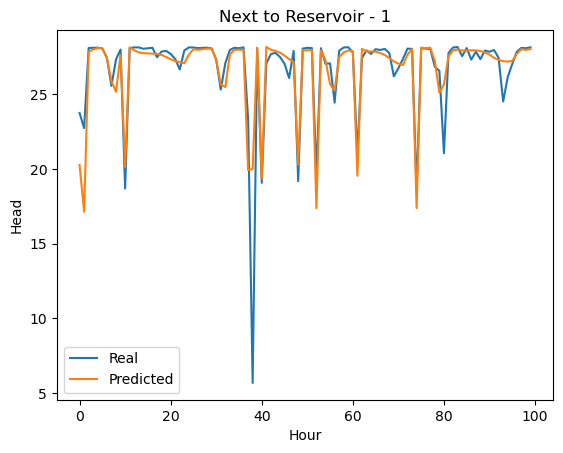

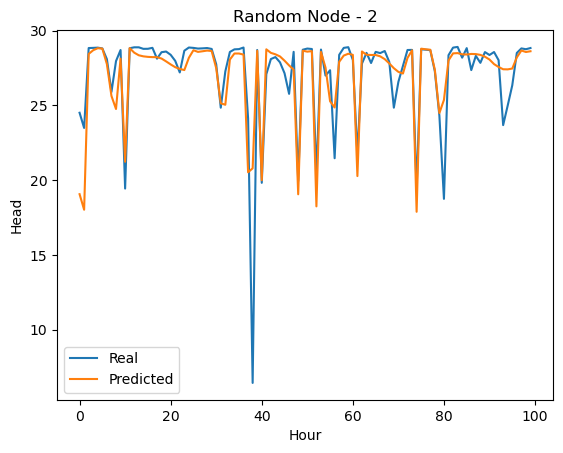

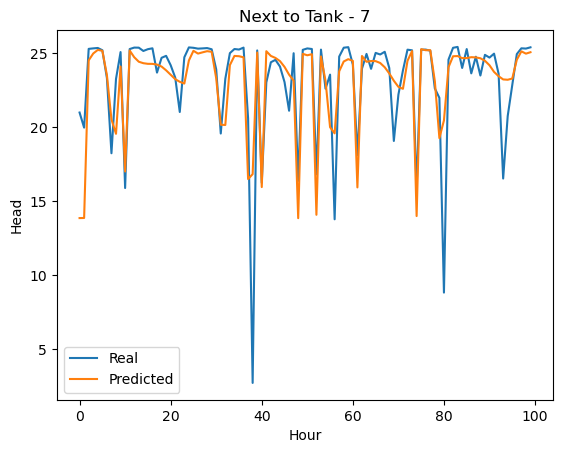

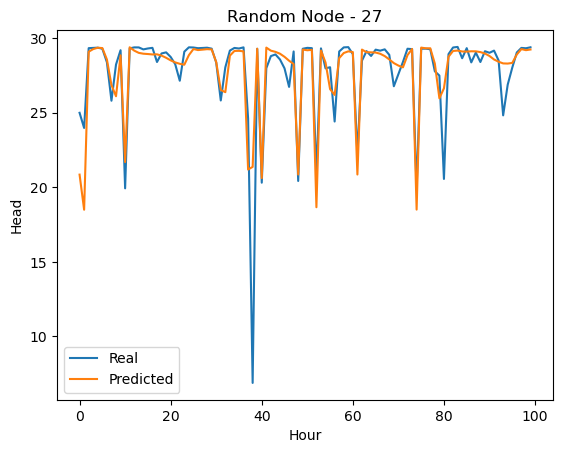

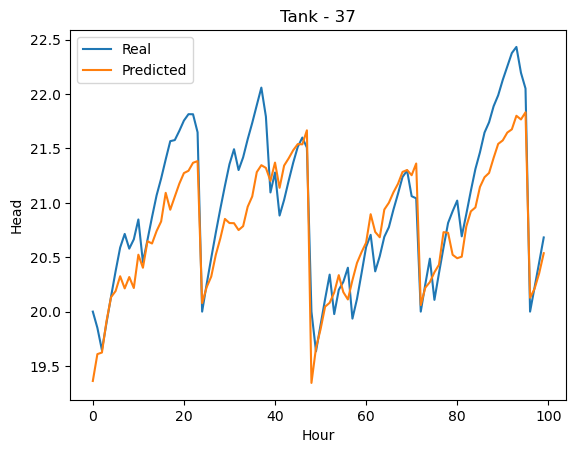

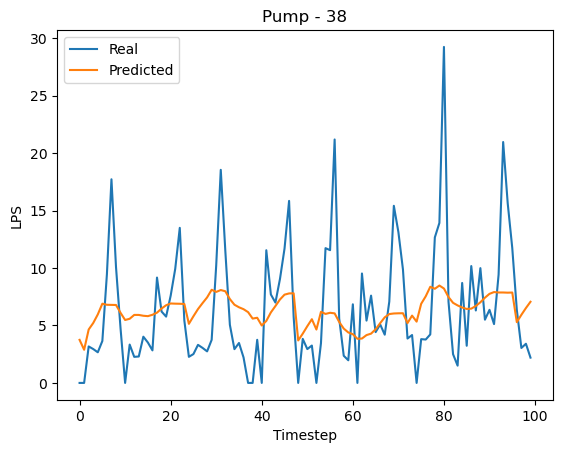

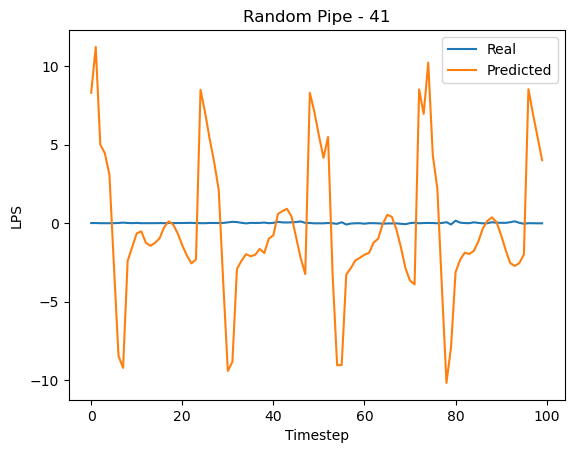

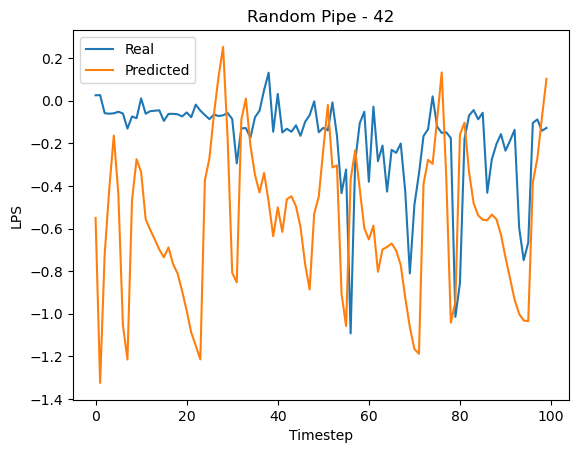

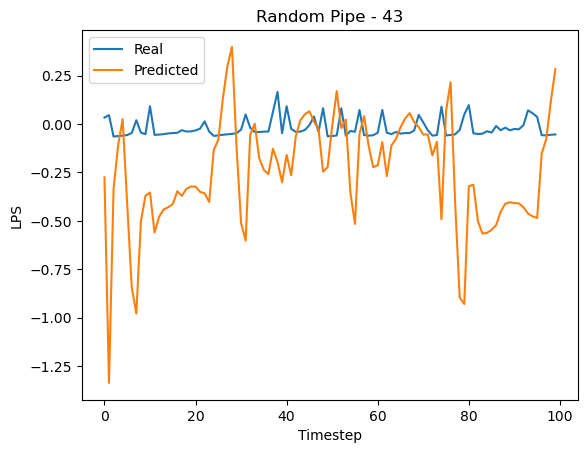

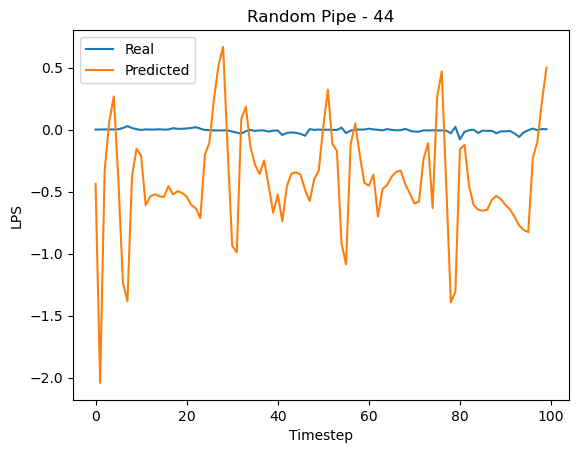

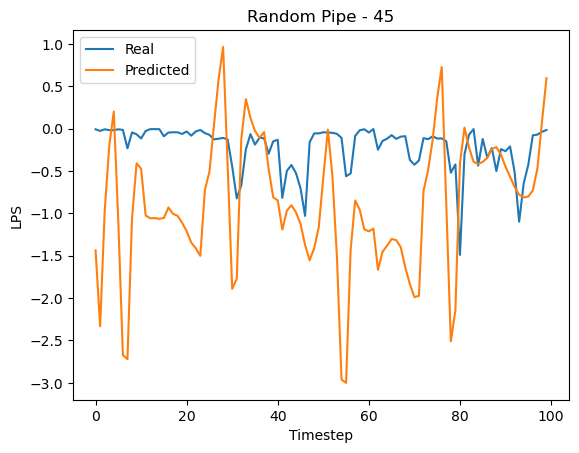

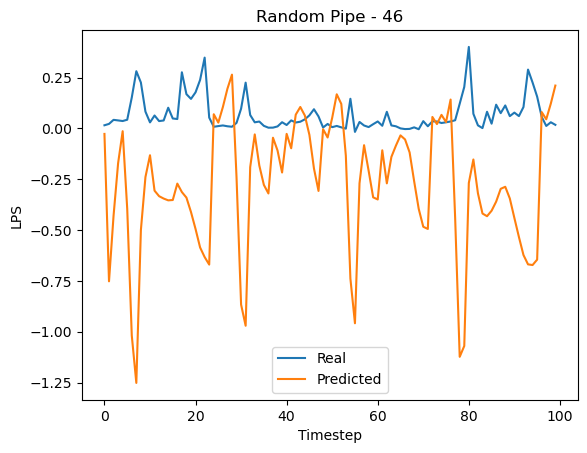

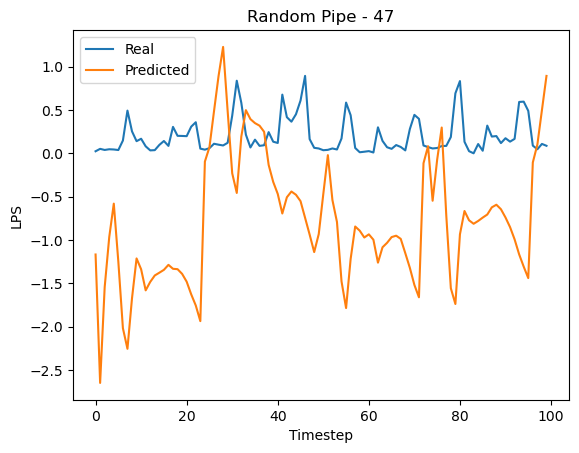

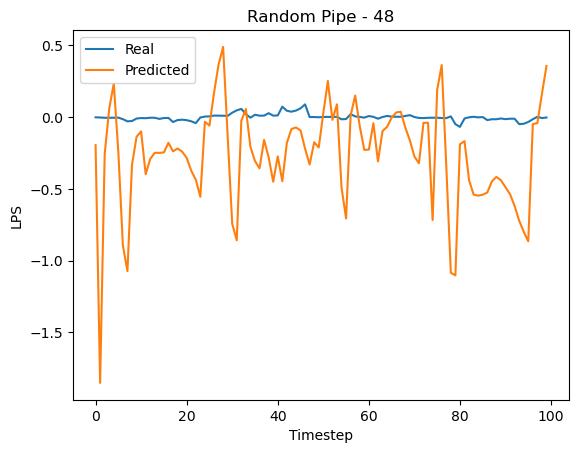

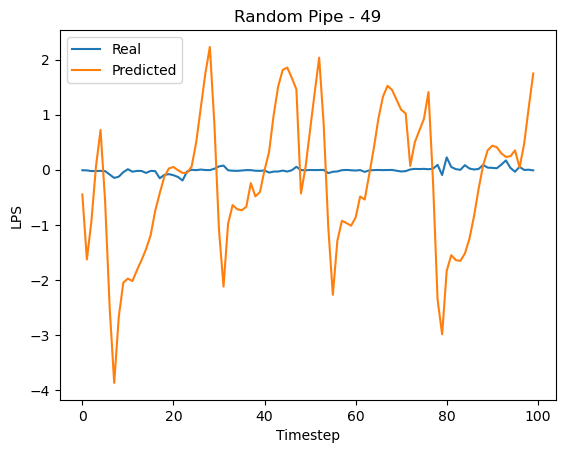

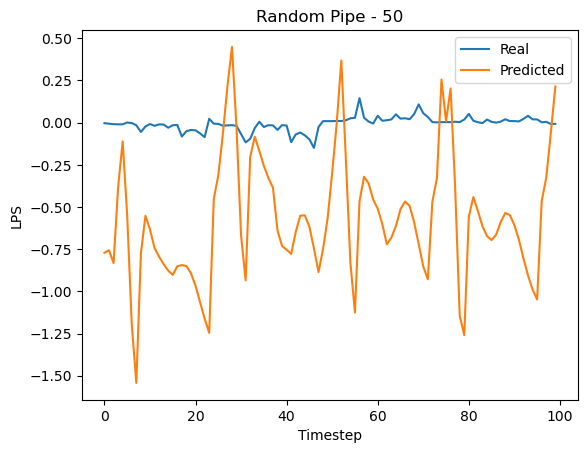

In [24]:
from utils.Dashboard import Dashboard
_, _, _, pred, real, timed = testing(model, tst_loader, normalization=gn)

pred = gn.denormalize_multiple(pred, output_nodes)
real = gn.denormalize_multiple(real, output_nodes)
real_flow = real[:, 37:]

dummy = Dummy(junctions + tanks).evaluate(real)
# Array below is created to ensure proper indexing of the nodes when displaying
type_array = (tst_database[0].node_type == 0) | (tst_database[0].node_type == 2)
d = Dashboard(pd.DataFrame(real[0:24, :]), pd.DataFrame(pred[0:24, :]),
              to_networkx(tst_dataset[0], node_attrs=['pos', 'ID']), type_array)
# f = d.display_results()

# for i in range(0, len(real[:]), 5):
for i in [0, 1, 6, 26, 36]:
    plt.plot(real[0:100, i], label="Real")
    plt.plot(pred[0:100, i], label="Predicted")
    # if i in [1, 6]:
        # plt.plot(dummy[0:100, i], label="Dummy")
    plt.ylabel('Head')
    plt.xlabel('Hour')
    
    plt.legend()
    names = {0: 'Next to Reservoir', 1: 'Random Node', 6: 'Next to Tank', 26: 'Random Node', 36: 'Tank', 37: 'Pump'}
    plt.title(names[i] + ' - ' + str(i + 1))
    # save_response_graphs_in_ML_tracker(real, pred, names[i], i)
    plt.show()
    plt.close()

plt.plot(real[0:100, 95], label="Real")
plt.plot(pred[0:100, 95], label="Predicted")
# plt.plot(dummy[0:100, 37], label="Dummy")
plt.ylabel('LPS')
plt.xlabel('Timestep')
# 
plt.legend()
plt.title(names[37] + ' - ' + str(37 + 1))
plt.show()
plt.close()

for i in range(40, 50):
    plt.plot(real[0:100, i], label="Real")
    plt.plot(pred[0:100, i], label="Predicted")
    # plt.plot(dummy[0:100, 37], label="Dummy")
    plt.ylabel('LPS')
    plt.xlabel('Timestep')
    # 
    plt.legend()
    plt.title('Random Pipe' + ' - ' + str(i + 1))
    plt.show()
    plt.close()

# save_response_graphs_in_ML_tracker(real, pred, names[i], i)
# Create a table

# Add Plotly figure as HTML file into Table
table = wandb.Table(columns = ["Figure" + str(i)])
# with open('./my_HTML_' + str(i) + '.html', 'r', encoding='utf-8') as file:
#     html_content = file.read()
# table.add_data(wandb.Html(html_content))
# display(f)
# wandb.finish()


In [21]:
# retrieve wntr data
tra_database, val_database, tst_database = load_raw_dataset(all_wdn_names[0], data_folder)
# reduce training data
# tra_database = tra_database[:int(len(tra_database)*cfg['tra_prc'])]
if cfg['tra_num'] < len(tra_database):
    tra_database = tra_database[:cfg['tra_num']]


# get GRAPH datasets     
# later on we should change this and use normal scalers from scikit (something is off here)
tra_dataset, A12_bar = create_dataset(tra_database)
flows = torch.stack(tra_dataset[0].y).numpy()[:, 37:, 0]
# number of nodes
junctions = (tra_database[0].node_type == JUNCTION_TYPE).numpy().sum()
tanks = (tra_database[0].node_type == TANK_TYPE).numpy().sum()
output_nodes = len(tra_dataset[0].y[0]) # remove reservoirs
gn = GraphNormalizer(junctions + tanks, output=['pressure', 'pump_flow'])
gn = gn.fit(tra_dataset)

# transformed = gn.transform_multiple(flows, output_nodes)
# inverse = gn.denormalize_multiple(transformed, output_nodes)

# The normalization messed with the 1H_type since we want unique IDs
tra_dataset, _ = create_dataset(tra_database, normalizer=gn)
node_size, edge_size = tra_dataset[0].x.size(-1), tra_dataset[0].edge_attr.size(-1)

# dataloader
# transform dataset for MLP
A10, A12 = create_incidence_matrices(tra_dataset, A12_bar)
tra_dataset_MLP, num_inputs, indices = create_dataset_MLP_from_graphs(tra_dataset)
tra_loader = torch.utils.data.DataLoader(tra_dataset_MLP,
                                         batch_size=batch_size, shuffle=False, pin_memory=True)
_, _, _, pred, real, timed = testing(model, tra_loader, normalization=gn)
real = gn.denormalize_multiple(real, output_nodes)
flows_den = real[:, 37:]
print('wat')

wat


In [25]:

def nse(observed, simulated):
    """
    Calculate Nash-Sutcliffe Efficiency (NSE) for 2D tensors.

    Args:
    observed (torch.Tensor): Tensor containing observed values.
    simulated (torch.Tensor): Tensor containing simulated values.

    Returns:
    NSE (float): Nash-Sutcliffe Efficiency value.
    """
    assert observed.shape == simulated.shape, "Input tensors must have the same shape."
    mean_observed = torch.mean(observed)
    numerator = torch.sum((observed - simulated) ** 2)
    denominator = torch.sum((observed - mean_observed) ** 2)
    
    nse = 1 - (numerator / denominator)
    return nse.item()

dummy_score = r2_score(real, dummy, multioutput='variance_weighted')
model_score = r2_score(real, pred, multioutput='variance_weighted')
print("R2-values \n", "Dummy:", dummy_score, "\n Model", model_score)

# dummy_score = mean_absolute_error(real, dummy)
# model_score = mean_absolute_error(real, pred)
# print("MAE-values \n", "Dummy:", dummy_score, "\n Model", model_score)

dummy_score = mean_squared_error(real, dummy)
model_score = mean_squared_error(real, pred)
print("MSE-values \n", "Dummy:", dummy_score, "\n Model", model_score)

# dummy_score = mean_squared_error(real, dummy, squared=False)
# model_score = mean_squared_error(real, pred, squared=False)
# print("RMSE-values \n", "Dummy:", dummy_score, "\n Model", model_score)

dummy_score = nse(real, dummy)
model_score = nse(real, pred)
print("NSE-values \n", "Dummy:", dummy_score, "\n Model", model_score)

dummy_scores = []
model_scores = []

for i in range(96):
    dummy_score = nse(real[:, i], dummy[:, i])
    model_score = nse(real[:, i], pred[:, i])
    dummy_scores.append(dummy_score)
    model_scores.append(model_score)
    
    print("NSE-values for node", i, dummy_score, model_score)


R2-values 
 Dummy: 0.4673719229721532 
 Model 0.41076342316615455
MSE-values 
 Dummy: 3.1108887 
 Model 3.4415178
NSE-values 
 Dummy: 0.9823299646377563 
 Model 0.9804519414901733
NSE-values for node 0 0.9686499834060669 0.6839755177497864
NSE-values for node 1 0.9612545371055603 0.6319252252578735
NSE-values for node 2 0.8872087597846985 0.6438981294631958
NSE-values for node 3 0.7132195830345154 0.6594870686531067
NSE-values for node 4 0.4584997892379761 0.5153995752334595
NSE-values for node 5 0.7767418622970581 0.580235481262207
NSE-values for node 6 0.0287020206451416 0.6208052635192871
NSE-values for node 7 0.6244277954101562 0.6240717768669128
NSE-values for node 8 0.7976522445678711 0.6449575424194336
NSE-values for node 9 0.9611556529998779 0.6806168556213379
NSE-values for node 10 0.9146036505699158 0.6767668724060059
NSE-values for node 11 0.7212796211242676 0.6684648990631104
NSE-values for node 12 0.5904539823532104 0.590357780456543
NSE-values for node 13 0.75430059432983

In [ ]:
import time
from datetime import datetime


with open(f'{results_folder}/{wdn}/{algorithm}/model.pickle', 'rb') as handle:
    loaded_model = torch.load(handle)
    loaded_model.eval()
    

# print(len(tra_dataset_MLP), len(tra_dataset_MLP[0]), len(tra_dataset_MLP[0][0]))
input = tra_dataset_MLP[0][0].unsqueeze(0).to(device)
print(input.shape)

start_time = time.time_ns()
print(start_time)
for batch in tra_loader:
    input = batch[0].to(device)
    output = model(input)

end_time = time.time_ns()
print(end_time)

print(f"Simulation time: {end_time - start_time}")

output = output.detach().cpu().numpy()
real = gn.inverse_transform_array(output, 'pressure')
print(real)

In [ ]:
import os
import regex as re

# Directory path where you want to search
directory_path = "./experiments"

# Get a list of all subdirectories in the specified directory
subdirectories = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

# Filter and extract the numbers from directory names
wdn_numbers = []
for subdir in subdirectories:
    match = re.match(r'unrolling_WDN(\d{4})', subdir)
    if match:
        wdn_numbers.append(int(match.group(1)))

# Find the latest WDN number
latest_wdn_number = None
if wdn_numbers:
    latest_wdn_number = max(wdn_numbers)
    latest_wdn_folder = f'unrolling_WDN{latest_wdn_number:04d}'
    print(f"The latest WDN folder is: {latest_wdn_folder}")
else:
    print("No WDN folders found in the specified directory.")

if latest_wdn_folder is not None:
    real = pd.read_csv(f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/LSTM/pred/testing/real.csv').drop(
        columns=['Unnamed: 0'])
    lstm_pred = pd.read_csv(
        f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/LSTM/pred/testing/0.csv').drop(
        columns=['Unnamed: 0'])
    unrolling_pred = pd.read_csv(
        f'./experiments/unrolling_WDN{latest_wdn_number:04d}/FOS_tank/BaselineUnrolling/pred/testing/0.csv').drop(
        columns=['Unnamed: 0'])

In [ ]:
import matplotlib.pyplot as plt

# Not sure if below makes sense since we now have an extra dimension
res = real.sub(lstm_pred).pow(2).sum(axis=0)
tot = real.sub(lstm_pred.mean(axis=0)).pow(2).sum(axis=0)
r2_lstm = 1 - res / tot
res = real.sub(unrolling_pred).pow(2).sum(axis=0)
tot = real.sub(unrolling_pred.mean(axis=0)).pow(2).sum(axis=0)
r2_unrolling = 1 - res / tot
r2s = pd.concat([r2_lstm, r2_unrolling], axis=1).rename(columns={0: 'LSTM', 1: 'Base-U'})
fig, ax = plt.subplots()
r2s.plot.box(ax=ax)
ax.set_title("$R^2$ Scores Comparison for PES")
ax.set_ylabel('$R^2$ Score')
plt.show()

In [ ]:
model = torch.load(f'{results_folder}/{wdn}/{algorithm}/model.pickle')

In [ ]:
# print(len(tra_dataset_MLP[0][0][indices['demand_timeseries']]))
print(len(tra_dataset_MLP))

for i in indices:
    
    if i != 'coeff_r' and i != 'coeff_n':
        variable = []
        for sample in tra_dataset_MLP:
            
            variable = variable + (list(sample[0][indices[i]].numpy()))
        
        print(len(variable)/800)
        
        counts, bins = np.histogram(variable, bins=12)
        plt.stairs(counts, bins)
        plt.xlabel(i)
        plt.ylabel('Occurence')
        plt.show()
# def plot_histograms():